In [1]:
import pandas as pd

df = pd.read_csv("D:/Ramadhanul Husna/ds-takehome/data/credit_scoring.csv")


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [3]:
df.describe()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
count,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,503999.500000,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167,0.012167,0.011945
std,1732.195139,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639,0.109639,0.113947
min,501000.000000,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000,0.000000,-0.119000
25%,502499.750000,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000,0.000000,-0.020000
50%,503999.500000,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000,0.000000,0.000000
75%,505499.250000,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000,0.000000,0.021000
max,506999.000000,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000,1.000000,1.092000


In [4]:
df = df.drop(columns=["leak_col_good", "leak_col_subtle"])


In [5]:
df

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41,13995609,5982664,0,624,0
1,501001,58,13683833,3711198,0,809,0
2,501002,33,9417391,7172332,0,647,0
3,501003,45,6861811,8661056,0,450,0
4,501004,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0
5996,506996,40,9944385,4082038,1,477,0
5997,506997,28,9048532,14760384,0,450,0
5998,506998,51,6843160,11774594,0,561,0


In [6]:
features = ['age', 'monthly_income', 'loan_amount', 'previous_defaults', 'credit_score']
target = 'default'

from sklearn.model_selection import train_test_split

X = df[features]
y = df[target]
application_ids = df["application_id"]  # disimpan secara terpisah

# Simpan juga index supaya nanti bisa ambil ID berdasarkan index
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, application_ids, stratify=y, test_size=0.2, random_state=42
)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

probs_lr = lr.predict_proba(X_test)[:, 1]
print("AUC Logistic Regression:", roc_auc_score(y_test, probs_lr))


AUC Logistic Regression: 0.6958649789029536


In [8]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

probs_gb = gb.predict_proba(X_test)[:, 1]
print("AUC Gradient Boosting:", roc_auc_score(y_test, probs_gb))


AUC Gradient Boosting: 0.6863009845288326


In [9]:
def prob_to_score(prob, min_score=300, max_score=850):
    return min_score + (1 - prob) * (max_score - min_score)

scores = prob_to_score(probs_gb)

score_df = pd.DataFrame({
    "application_id": id_test.values,
    "Prob Default": probs_gb,
    "Credit Score (300–850)": scores
})

print(score_df.head(10))


   application_id  Prob Default  Credit Score (300–850)
0          501730      0.002240              848.768139
1          505541      0.007230              846.023350
2          505065      0.000429              849.764045
3          502030      0.003420              848.118757
4          503346      0.001514              849.167203
5          501406      0.000885              849.513446
6          506293      0.001858              848.978244
7          501678      0.003039              848.328504
8          503718      0.005216              847.131405
9          501506      0.000698              849.615893


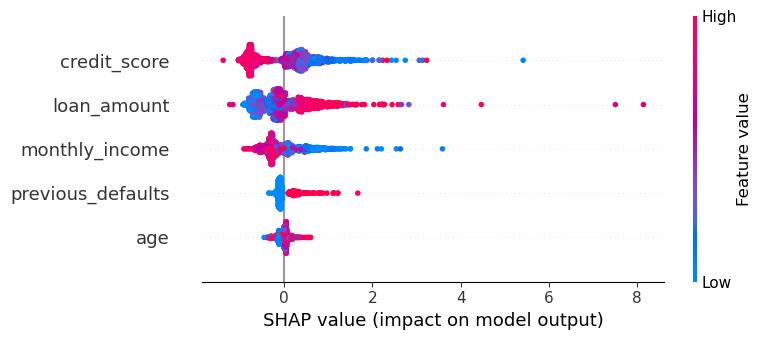

In [9]:
import shap
explainer = shap.Explainer(gb, X_train)
shap_values = explainer(X_test)

# Top 10 fitur
shap.summary_plot(shap_values, X_test, max_display=10, show=False)

import matplotlib.pyplot as plt
plt.savefig("shap_top10.png")  # <-- ini yang akan dikumpulkan


In [10]:
# Ambil 1 nasabah contoh
sample = X_test.iloc[[0]]
sample_id = df.loc[sample.index[0], 'application_id']
sample_prob = gb.predict_proba(sample)[0, 1]
sample_score = prob_to_score(sample_prob)

# Tampilkan hasil
print("Application ID:", sample_id)
print(f"Probabilitas gagal bayar: {sample_prob:.2f}")
print(f"Skor risiko: {sample_score:.0f}")


shap_values_sample = explainer(sample)
shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'shap_value': shap_values_sample.values[0]
})
top3 = shap_df.reindex(shap_df.shap_value.abs().sort_values(ascending=False).index).head(3)

print("\nTop 3 fitur penyumbang risiko:")
print(top3)


Application ID: 501822
Probabilitas gagal bayar: 0.00
Skor risiko: 848

Top 3 fitur penyumbang risiko:
             feature  shap_value
3  previous_defaults    1.114489
4       credit_score   -0.408322
1     monthly_income   -0.306477


In [11]:
# Pinjaman yang diminta
jumlah_pinjaman = 5_000_000  # 5 juta rupiah

# Ambil 1 contoh nasabah
sample = X_test.iloc[[0]]
prob_default = gb.predict_proba(sample)[0, 1]
skor = prob_to_score(prob_default)

# Hitung potensi kerugian
resiko_kerugian = prob_default * jumlah_pinjaman

print(f"Probabilitas gagal bayar: {prob_default:.2f}")
print(f"Skor risiko (300–850): {skor:.0f}")
print(f"Estimasi kerugian jika gagal bayar: IDR {resiko_kerugian:,.0f}")


Probabilitas gagal bayar: 0.00
Skor risiko (300–850): 848
Estimasi kerugian jika gagal bayar: IDR 20,737


In [12]:
# Salin test set
test_set = X_test.copy()

# Prediksi probabilitas default
test_set["PD"] = gb.predict_proba(X_test)[:, 1]

# Hitung skor risiko
test_set["Scorecard"] = prob_to_score(test_set["PD"])  # Ganti nama di sini

# Asumsi
EAD = 5_000_000  # 5 juta
LGD = 1.0  # 100%
batas_kerugian = 1_000_000  # maksimal risiko kerugian

# Hitung estimasi kerugian
test_set["Expected_Loss"] = test_set["PD"] * LGD * EAD

# Keputusan
test_set["Keputusan"] = test_set.apply(
    lambda row: "Disetujui" if row["Scorecard"] >= 650 and row["Expected_Loss"] <= batas_kerugian else "Ditolak",
    axis=1
)

# Tambahkan application_id dan default dari data asli
test_set["application_id"] = df.loc[test_set.index, "application_id"]
test_set["default_actual"] = df.loc[test_set.index, "default"]

# Tampilkan sebagian hasil
test_set[["application_id", "Scorecard", "PD", "Expected_Loss", "Keputusan"]].head()


,application_id,Scorecard,PD,Expected_Loss,Keputusan
822,501822,847.718889,0.004147,20737.375791,Disetujui
3853,504853,849.571665,0.000779,3893.950526,Disetujui
5086,506086,848.665488,0.002426,12131.927361,Disetujui
1931,502931,845.066813,0.008969,44847.157703,Disetujui
2209,503209,847.148021,0.005185,25927.086258,Disetujui


In [14]:
# Tampilkan sebagian hasil
test_set[["application_id", "Scorecard", "PD", "Expected_Loss", "Keputusan"]].head(100)

,application_id,Scorecard,PD,Expected_Loss,Keputusan
822,501822,847.718889,0.004147,20737.375791,Disetujui
3853,504853,849.571665,0.000779,3893.950526,Disetujui
5086,506086,848.665488,0.002426,12131.927361,Disetujui
1931,502931,845.066813,0.008969,44847.157703,Disetujui
2209,503209,847.148021,0.005185,25927.086258,Disetujui
...,...,...,...,...,...
1809,502809,844.508444,0.009985,49923.233753,Disetujui
117,501117,835.171506,0.026961,134804.490100,Disetujui
1867,502867,846.248895,0.006820,34100.952457,Disetujui
1391,502391,848.878181,0.002040,10198.354102,Disetujui


In [13]:
ditolak = test_set[test_set["Keputusan"] == "Ditolak"]
ditolak_tampil = ditolak[["application_id", "Scorecard", "PD", "Expected_Loss", "Keputusan"]]
print(ditolak_tampil.head(10))  # tampilkan 10 teratas


      application_id   Scorecard        PD  Expected_Loss Keputusan
3818          504818  492.567108  0.649878   3.249390e+06   Ditolak
3813          504813  469.938680  0.691021   3.455103e+06   Ditolak
2136          503136  736.726036  0.205953   1.029763e+06   Ditolak
2737          503737  671.677876  0.324222   1.621110e+06   Ditolak
2651          503651  339.448962  0.928275   4.641373e+06   Ditolak
